<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/A_MSDS458_Assignment_03_EDA_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3 - Part 00

## Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

In [1]:
#!conda install -c anaconda tensorflow-datasets --y
#!pip install -c anaconda tensorflow-datasets --y

##Functions and Packages

### Import packages 

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Visualization Utility Functions

In [4]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Vectorization Class

In [5]:
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)


### Verify TensorFlow Version and Keras Version

In [6]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [7]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


##Mount Google Colab

In [8]:
 from google.colab import drive
 drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Read Data - TWO OPTIONS (from CSV from Google drive OR from Kaggle)

### OPTION 1: AG_NEWS_SUBSET Data in CSV files from Google drive
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See  https://www.kaggle.com/amananandrai/ag-news-classification-dataset
 
  <li>We combined the Title and Description columns into a Title_Description column in the training and test csv files.</li>
  <li>We also created a validation csv file using some of the data from the training csv file.</li>
</ol>

 </div>

In [9]:
train_df = pd.read_csv('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/train.csv')
val_df = pd.read_csv('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/val.csv')
test_df = pd.read_csv('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/test.csv')
all_df = pd.read_csv('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/all.csv')

print(f"There are {train_df.shape[0]} news articles for training.")
print(f"There are {val_df.shape[0]} news articles for validation.")
print(f"There are {test_df.shape[0]} news articles for testing.")
print(f"There are {all_df.shape[0]} news articles total.")

There are 114000 news articles for training.
There are 6000 news articles for validation.
There are 7600 news articles for testing.
There are 127600 news articles total.


In [10]:
type(train_df)

pandas.core.frame.DataFrame

In [11]:
train_df.head(2)

,Label,Title,Description,Title_Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...


In [12]:
test_df.head(2).T

,0,1
Label,2,3
Title,Fears for T N pension after talks,The Race is On: Second Private Team Sets Launc...
Description,Unions representing workers at Turner Newall...,"SPACE.com - TORONTO, Canada -- A second\team o..."
Title_Description,Fears for T N pension after talks Unions repre...,The Race is On: Second Private Team Sets Launc...


In [13]:
val_df.head(2).T

,0,1
Label,0,0
Title,US shrugs off report of ransom,Clinton Making Satisfactory Recovery
Description,The Bush administration yesterday gave Italy t...,NEW YORK - Breathing on his own and sipping li...
Title_Description,US shrugs off report of ransom The Bush admini...,Clinton Making Satisfactory Recovery NEW YORK ...


In [14]:
categories = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
all_df.Label.value_counts(sort=False).rename(index=categories)

Business    31900
Sci/Tech    31900
Sports      31900
World       31900
Name: Label, dtype: int64

In [15]:
## Convert to TensorFlow datasets
batch_size = 32
train_ds =\
tf.data.experimental.make_csv_dataset('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/train.csv',select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1, batch_size=batch_size)
val_ds =\
tf.data.experimental.make_csv_dataset('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/val.csv',select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1,batch_size=batch_size)
test_ds =\
tf.data.experimental.make_csv_dataset('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/test.csv',select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1,batch_size=batch_size)
all_ds =\
tf.data.experimental.make_csv_dataset('gdrive/My Drive/MSDS 458/MSDS_458_Public-master/MSDS458_Assignment_03/data/all.csv',select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1, batch_size=1)

In [16]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [17]:
## Would not run
#len(train_ds), len(val_ds), len(test_ds)

In [18]:
## Review Examples By Classification
categories = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
all_df.Label.value_counts(sort=False).rename(index=categories)

Business    31900
Sci/Tech    31900
Sports      31900
World       31900
Name: Label, dtype: int64

In [19]:
## Review first article in train dataset
for inputs, targets in train_ds:
    print(f"The first batch has {inputs['Title_Description'].shape[0]} articles with {targets.shape[0]} labels.")
    print(f"The articles have type {inputs['Title_Description'].dtype}, the labels type: {targets.dtype}\n")
    
    # just print the first news article in the batch
    print(f"The first news article:\n{inputs['Title_Description'][0]}\n") 

    print(f"It is a {categories[targets[0].numpy()]} article.")
    break

The first batch has 32 articles with 32 labels.
The articles have type <dtype: 'string'>, the labels type: <dtype: 'int32'>

The first news article:
b'Softball gold takes Candrea, US from tragedy to triumph To the rest of the world, they were the  quot;In Your Dreams quot; Team. But for their coach, Mike Candrea, it was about another dream.'

It is a Sports article.


## Preorocessing


In [20]:
# By default, the TextVectorization layer will use the setting “convert to lowercase and remove punctuation” for text standardization, and “split on whitespace” for tokenization.
text_vectorization = TextVectorization(
    output_mode="int",
)
text_only_all_ds = all_ds.map(lambda x, y: x['Title_Description'])

In [21]:
for text in text_only_all_ds:
    print(f"Get first batch of {text.shape[0]} news articles.\n")
    print(f"Here is the first news article:\n\n{text[0]}.")
    break

Get first batch of 1 news articles.

Here is the first news article:

b'Pay-Per-View Revenue Boosts WWE Profit  NEW YORK (Reuters) - World Wrestling Entertainment Inc.  &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=WWE.N target=/stocks/quickinfo/fullquote"&gt;WWE.N&lt;/A&gt;, a producer of wrestling entertainment programs  including "SmackDown" and "WrestleMania," reported higher  quarterly profit on Monday, helped by increased pay-per-view  revenue.'.


Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

In [22]:
%%time
text_vectorization.adapt(text_only_all_ds)

CPU times: user 2min 9s, sys: 16 s, total: 2min 25s
Wall time: 1min 50s


In [23]:
for text in text_only_all_ds:
    print(f"Get first batch of {text.shape[0]} news articles.\n")
    print(f"Here is the first news article:\n\n{text[0]}.")
    break

Get first batch of 1 news articles.

Here is the first news article:

b"AT T strikes VoIP deals with cable Company points potential Net phone customers to cable giants for broadband--all part of Ma Bell's aggressive VoIP plans.".


## Vocabulary Words In Corpus

In [24]:
vocab = text_vectorization.get_vocabulary()
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 105275 vocabulary words in the corpus.


## Example 12 Words 

In [25]:
vocab[:12]

['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for', '39s', 'that']

## Vectorization - Title Description Column

In [26]:
%%time
doc_sizes = []
corpus = []
for example, _ in all_ds:
  enc_example = text_vectorization(example['Title_Description'])
  doc_sizes.append(enc_example.shape[1])
  corpus+=list(enc_example.numpy()[0])

CPU times: user 7min 7s, sys: 11 s, total: 7min 18s
Wall time: 7min 21s


In [27]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 4773046 words in the corpus of 127600 news articles.
Each news article has between 4 and 177 tokens in it.


In [28]:
corpus[:5]

[9416, 9384, 1107, 3341, 142]

## Plot Distribution of Percent of Non-Vocabulary Words in News Articles

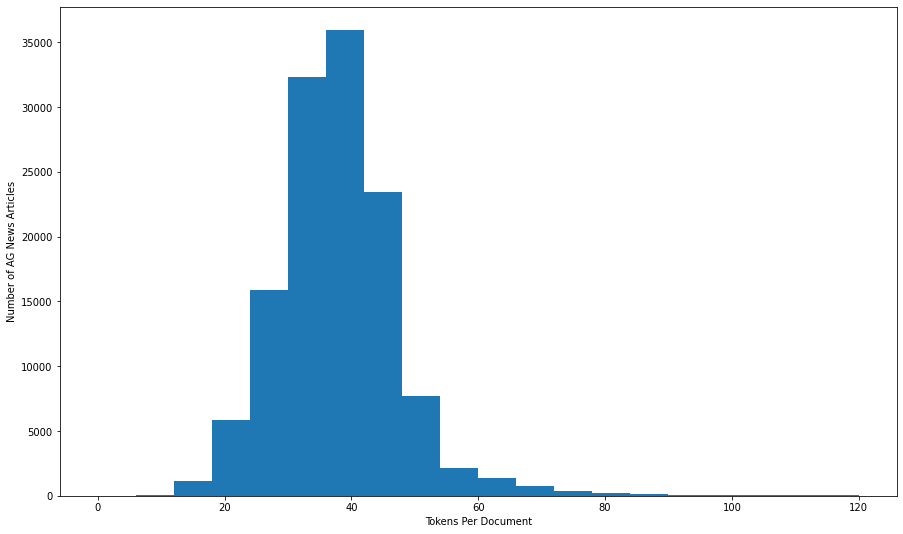

In [29]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

##Experiment A: EDA

###Part a

Tweak the vocabulary size, at least 3 levels

#### Level 1, vocab size: 500 

In [30]:
%%time
from tensorflow.keras.layers import TextVectorization
encoder_500 = TextVectorization(
    output_mode="int",
    max_tokens=500
)
encoder_500.adapt(text_only_all_ds)
vocab_500 = np.array(encoder_500.get_vocabulary());

CPU times: user 2min 10s, sys: 15.7 s, total: 2min 26s
Wall time: 2min 21s


In [31]:
## Excample 20 Words
vocab_500[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for',
       '39s', 'that', 'with', 'as', 'at', 'its', 'is', 'new', 'by',
       'said'], dtype='<U13')

In [32]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_500(example).numpy()
enc_example

array([  2,   1,   1,  29,   4, 178,   1,  13,  20,   1,  18,   2,   1,
         8,   2,   1])

In [33]:
## ## Zero and One are Special Value Integers ( 0 = Padding, 1 = Unknown Word)
num_ones = tf.math.count_nonzero(enc_example==1).numpy()
num_ones

6

In [34]:
## Encode Sequences Leveraging 1000 Word Vocabulary 
%%time
doc500_sizes = []
corpus500 = []
count500=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_500(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc500_sizes.append(len(enc_example))
  corpus500+=list(enc_example.numpy())

  count500 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 49s, sys: 11.1 s, total: 9min
Wall time: 8min 30s


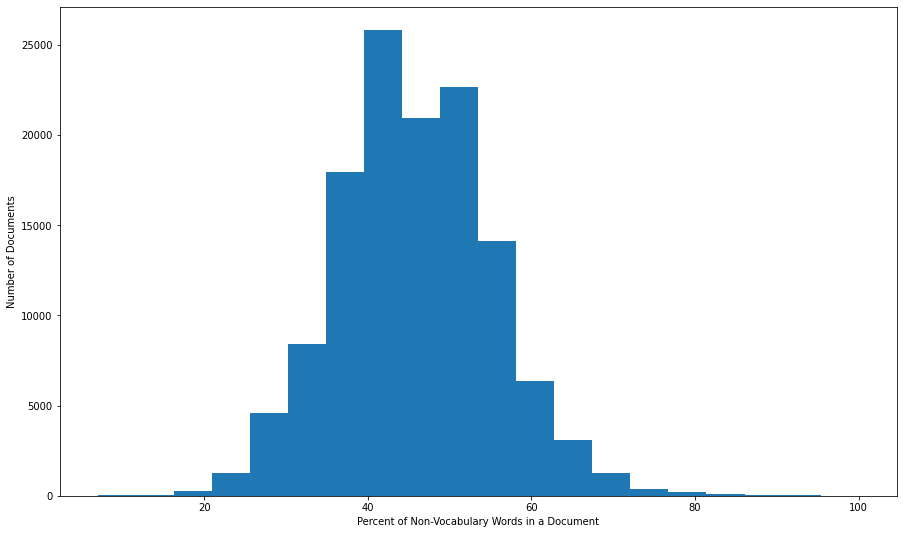

In [35]:
## Plot Distribution of Tokens Per News Article
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [36]:
print(f"Each news article has between {min(doc500_sizes)} and {max(doc500_sizes)} tokens in it.")

Each news article has between 4 and 177 tokens in it.


In [37]:
print(f"There are {count500} top {len(vocab_500)} vocabulary words in the corpus.")

There are 2609655 top 500 vocabulary words in the corpus.


#### Level 2, vocab size: 1,000 

In [38]:
%%time
from tensorflow.keras.layers import TextVectorization
encoder_1000 = TextVectorization(
    output_mode="int",
    max_tokens=1000
)
encoder_1000.adapt(text_only_all_ds)
vocab_1000 = np.array(encoder_1000.get_vocabulary());

CPU times: user 2min 8s, sys: 15.1 s, total: 2min 23s
Wall time: 1min 47s


In [39]:
## Excample 20 Words
vocab_1000[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for',
       '39s', 'that', 'with', 'as', 'at', 'its', 'is', 'new', 'by',
       'said'], dtype='<U14')

In [40]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_1000(example).numpy()
enc_example

array([  2,   1,   1,  29,   4, 178,   1,  13,  20,   1,  18,   2,   1,
         8,   2,   1])

In [41]:
## ## Zero and One are Special Value Integers ( 0 = Padding, 1 = Unknown Word)
num_ones = tf.math.count_nonzero(enc_example==1).numpy()
num_ones

6

In [42]:
## Encode Sequences Leveraging 1000 Word Vocabulary 
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_1000(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 9min 8s, sys: 12.1 s, total: 9min 21s
Wall time: 8min 46s


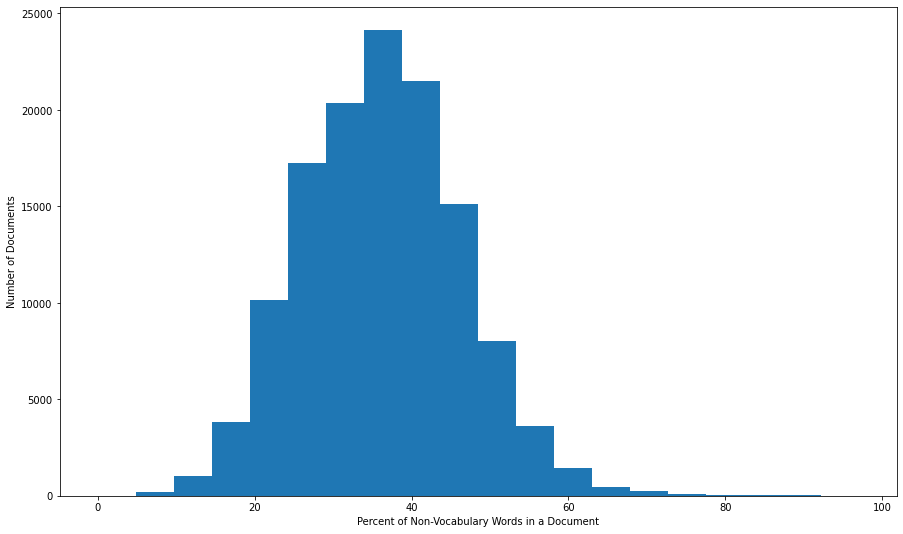

In [43]:
## Plot Distribution of Tokens Per News Article
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [44]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 4 and 177 tokens in it.


In [45]:
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 3061452 top 1000 vocabulary words in the corpus.


#### Level 3, vocab size: 8,000

In [46]:
%%time
from tensorflow.keras.layers import TextVectorization
encoder_8000 = TextVectorization(
    output_mode="int",
    max_tokens=8000
)
encoder_8000.adapt(text_only_all_ds)
vocab_8000 = np.array(encoder_8000.get_vocabulary());

CPU times: user 2min 9s, sys: 15.2 s, total: 2min 24s
Wall time: 1min 48s


In [47]:
## Excample 20 Words
vocab_8000[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for',
       '39s', 'that', 'with', 'as', 'at', 'its', 'is', 'new', 'by',
       'said'], dtype='<U52')

In [48]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_8000(example).numpy()
enc_example

array([   2, 5278, 1609,   29,    4,  178, 1468,   13,   20, 3188,   18,
          2, 1820,    8,    2, 1054])

In [49]:
## ## Zero and One are Special Value Integers ( 0 = Padding, 1 = Unknown Word)
num_ones = tf.math.count_nonzero(enc_example==1).numpy()
num_ones

0

In [50]:
## Encode Sequences Leveraging 1000 Word Vocabulary 
%%time
doc8000_sizes = []
corpus8000 = []
count8000=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_8000(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc8000_sizes.append(len(enc_example))
  corpus8000+=list(enc_example.numpy())

  count8000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 44s, sys: 11.2 s, total: 8min 56s
Wall time: 8min 25s


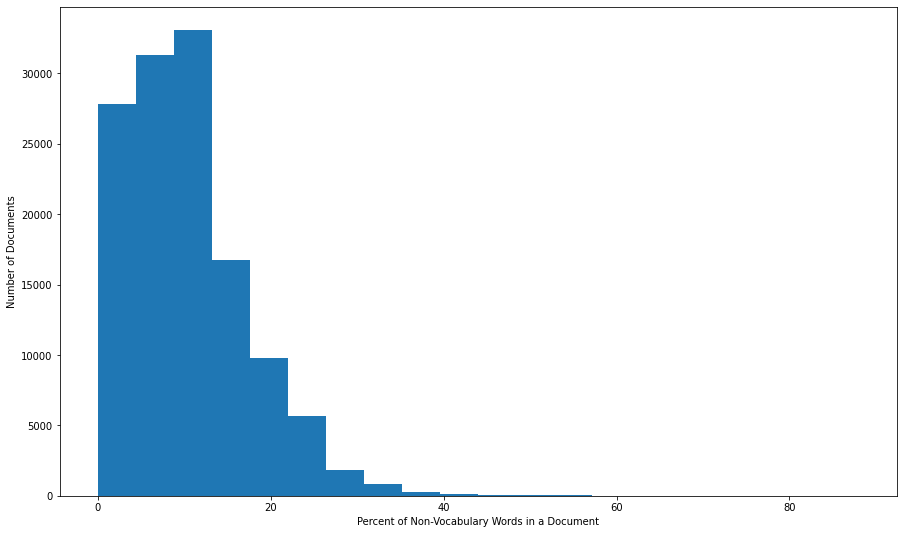

In [51]:
## Plot Distribution of Tokens Per News Article
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [52]:
print(f"Each news article has between {min(doc8000_sizes)} and {max(doc8000_sizes)} tokens in it.")

Each news article has between 4 and 177 tokens in it.


In [53]:
print(f"There are {count8000} top {len(vocab_8000)} vocabulary words in the corpus.")

There are 4295499 top 8000 vocabulary words in the corpus.


###Part b
Editing the Vocabulary: Try unedited most frequent words, VS edit the list by deleting the most frequent words such as articles, ‘the’, ‘a’, etc.

In [54]:
# Top 25 words from all_df

from collections import Counter
Counter(" ".join(all_df['Description']).split()).most_common(25)

[('the', 183490),
 ('to', 100936),
 ('a', 100359),
 ('of', 94260),
 ('in', 80008),
 ('and', 69279),
 ('on', 49107),
 ('-', 40397),
 ('for', 39128),
 ('that', 28545),
 ('#39;s', 26499),
 ('The', 25280),
 ('with', 22895),
 ('its', 22301),
 ('as', 21947),
 ('is', 20789),
 ('at', 20752),
 ('has', 19331),
 ('by', 18146),
 ('said', 17482),
 ('from', 16513),
 ('it', 16001),
 ('an', 15942),
 ('his', 15045),
 ('will', 14122)]

### Stopword Function

In [55]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [56]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [57]:
%%time
max_length = 150
max_tokens = 1000
encoder_stop_words = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords # removes stopwords
)

encoder_stop_words.adapt(text_only_all_ds)
vocab_stop_words = np.array(encoder_stop_words.get_vocabulary());

CPU times: user 2min 5s, sys: 14.8 s, total: 2min 20s
Wall time: 1min 46s


In [58]:
vocab_stop_words[:20]

array(['', '[UNK]', '39s', 'new', 'said', 'us', 'reuters', 'ap', 'first',
       'two', 'monday', 'world', 'wednesday', 'tuesday', 'oil',
       'thursday', 'company', 'one', 'friday', 'inc'], dtype='<U14')

In [59]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_stop_words(example).numpy()
enc_example

array([  1,   1, 118,   1,   1,   1, 953,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

#### Zero and One are Special Value Integers ( 0 = Padding, 1 = Unknown Word)

In [60]:
num_ones = tf.math.count_nonzero(enc_example==1).numpy()
num_ones

5

In [61]:
## Encode and remove stopwords

In [62]:
%%time
docstop_words_sizes = []
corpusstop_words = []
countstop_words=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_stop_words(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  docstop_words_sizes.append(len(enc_example))
  corpusstop_words+=list(enc_example.numpy())

  countstop_words += tf.math.count_nonzero(enc_example>1)

CPU times: user 8min 48s, sys: 11.8 s, total: 9min
Wall time: 8min 34s


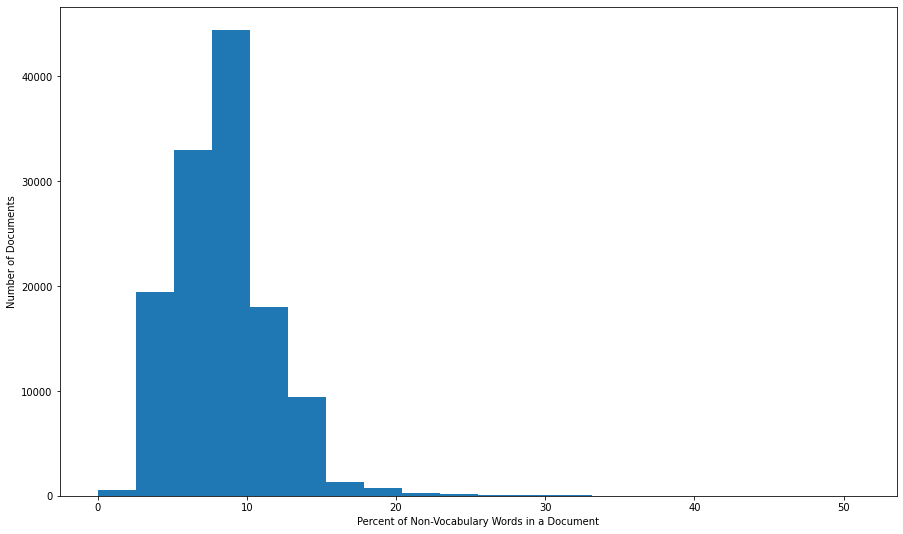

In [63]:
## Plot Distribution of Tokens Per News Article

plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [64]:
print(f"Each news article has between {min(docstop_words_sizes)} and {max(docstop_words_sizes)} tokens in it.")

Each news article has between 150 and 150 tokens in it.


###Part c
Output sequence length: Use the default VS set it to a fixed number

In [66]:
#1000 words vectoriezed with output length 100

%%time
from tensorflow.keras.layers import TextVectorization
encoder_output_sequence_length = TextVectorization(
    output_mode="int",
    max_tokens=1000,
    output_sequence_length=100 # output_sequence_length 
)
encoder_output_sequence_length.adapt(text_only_all_ds)
vocab_output_sequence_length = np.array(encoder_output_sequence_length.get_vocabulary());

CPU times: user 2min 5s, sys: 14.6 s, total: 2min 20s
Wall time: 1min 45s


In [67]:
vocab_output_sequence_length[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for',
       '39s', 'that', 'with', 'as', 'at', 'its', 'is', 'new', 'by',
       'said'], dtype='<U14')

In [68]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_output_sequence_length(example).numpy()
enc_example

array([  2,   1,   1,  29,   4, 178,   1,  13,  20,   1,  18,   2,   1,
         8,   2,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

#### Zero and One are Special Value Integers ( 0 = Padding, 1 = Unknown Word)

In [69]:
num_ones = tf.math.count_nonzero(enc_example==1).numpy()
num_ones

6

In [70]:
## Encode and remove stopwords

In [71]:
%%time
docoutput_sequence_length_sizes = []
corpusoutput_sequence_length = []
countoutput_sequence_length=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_output_sequence_length(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  docoutput_sequence_length_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  countoutput_sequence_length += tf.math.count_nonzero(enc_example>1)

CPU times: user 9min 13s, sys: 13.2 s, total: 9min 27s
Wall time: 8min 53s


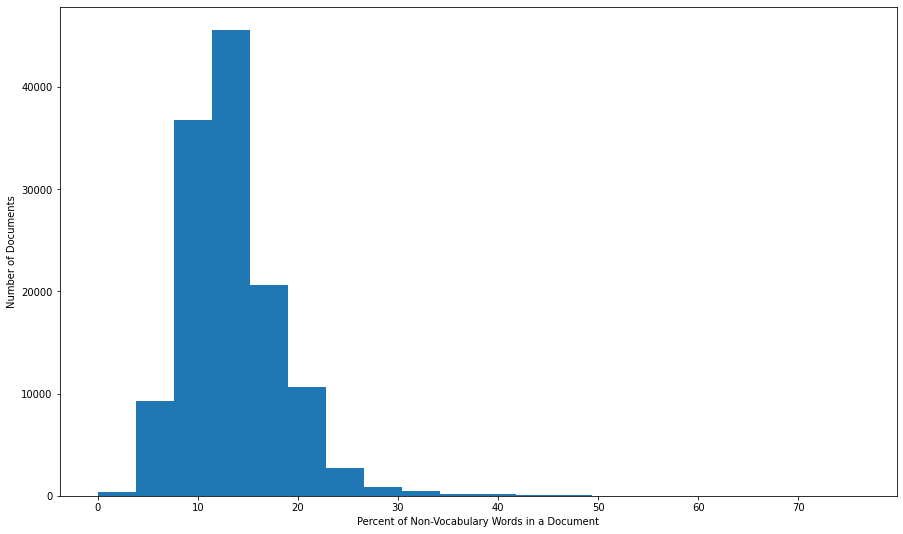

In [72]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [73]:
print(f"Each news article has between {min(docoutput_sequence_length_sizes)} and {max(docoutput_sequence_length_sizes)} tokens in it.")

Each news article has between 100 and 100 tokens in it.


In [74]:
print(f"There are {count8000} top {len(vocab_8000)} vocabulary words in the corpus.")

There are 4295499 top 8000 vocabulary words in the corpus.
